# 시계열 데이터 처리
- shift를 이용한 데이터 처리


## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 13})

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               

In [3]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

In [4]:
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test - y_pred, s=5)

# 에너지 사용 예측

## 데이터

- 한 가정의 3년간 시간 단위 에너지 사용 데이터를 이용

In [5]:
# power = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv",
#                  parse_dates=['timestamp'])
power = pd.read_csv("./energy.csv",
                 parse_dates=['timestamp'])
power.set_index("timestamp", inplace=True)

print(power.shape)
power[:3]

(26304, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


In [7]:
# 단변수 예측
# df = power[['load', 'temp']]
df_power = power[:24*365].copy()
print(df_power.shape)
df_power[:3]

(8760, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


# shift를 이용한 특성 추가

In [25]:
df = df_power.copy()

In [26]:
df["load-1"] = df["load"].shift(1)
df[:3]

,load,temp,load-1
timestamp,,,
2012-01-01 00:00:00,2698.0,32.000000,NaN
2012-01-01 01:00:00,2558.0,32.666667,2698.0
2012-01-01 02:00:00,2444.0,30.000000,2558.0


In [30]:
# 임의의 컬럼을 아래로 shift(n_shift) 수행하는 함수
def add_shifts(df_input, **cols):
    df = df_input.copy()
    for col, n_shift in cols.items():
        for i in range (1, n_shift+1):
            df[col+'-'+str(i)]=df[col].shift(i)
    return df

In [31]:
cols = {'load':3}
df_sh = add_shifts(df, **cols)
df_sh

,load,temp,load-1,load-2,load-3
timestamp,,,,,
2012-01-01 00:00:00,2698.0,32.000000,NaN,NaN,NaN
2012-01-01 01:00:00,2558.0,32.666667,2698.0,NaN,NaN
2012-01-01 02:00:00,2444.0,30.000000,2558.0,2698.0,NaN
2012-01-01 03:00:00,2402.0,31.000000,2444.0,2558.0,2698.0
2012-01-01 04:00:00,2403.0,32.000000,2402.0,2444.0,2558.0
...,...,...,...,...,...
2012-12-30 19:00:00,4119.0,17.666667,4253.0,4304.0,4065.0
2012-12-30 20:00:00,3977.0,16.666667,4119.0,4253.0,4304.0
2012-12-30 21:00:00,3736.0,16.666667,3977.0,4119.0,4253.0


In [33]:
# 예측할 목적 변수 설정: 특정 컬럼을 위로 한 행씩 이동
df["load+1"] = df["load"].shift(-1)
df

,load,temp,load-1,load+1
timestamp,,,,
2012-01-01 00:00:00,2698.0,32.000000,NaN,2558.0
2012-01-01 01:00:00,2558.0,32.666667,2698.0,2444.0
2012-01-01 02:00:00,2444.0,30.000000,2558.0,2402.0
2012-01-01 03:00:00,2402.0,31.000000,2444.0,2403.0
2012-01-01 04:00:00,2403.0,32.000000,2402.0,2453.0
...,...,...,...,...
2012-12-30 19:00:00,4119.0,17.666667,4253.0,3977.0
2012-12-30 20:00:00,3977.0,16.666667,4119.0,3736.0
2012-12-30 21:00:00,3736.0,16.666667,3977.0,3444.0


In [34]:
# 컬럼 y 를 future에서 지정한 수 만큼 위로 이동하는 함수
def add_y_values(df_input, y, *future):
    df = df_input.copy()
    for i in future:
        df[y+'+'+str(i)]=df[y].shift(-i)
    return df

In [35]:
future = list(range(1,3))
df_sh = add_y_values(df, 'load',*future)
df_sh

,load,temp,load-1,load+1,load+2
timestamp,,,,,
2012-01-01 00:00:00,2698.0,32.000000,NaN,2558.0,2444.0
2012-01-01 01:00:00,2558.0,32.666667,2698.0,2444.0,2402.0
2012-01-01 02:00:00,2444.0,30.000000,2558.0,2402.0,2403.0
2012-01-01 03:00:00,2402.0,31.000000,2444.0,2403.0,2453.0
2012-01-01 04:00:00,2403.0,32.000000,2402.0,2453.0,2560.0
...,...,...,...,...,...
2012-12-30 19:00:00,4119.0,17.666667,4253.0,3977.0,3736.0
2012-12-30 20:00:00,3977.0,16.666667,4119.0,3736.0,3444.0
2012-12-30 21:00:00,3736.0,16.666667,3977.0,3444.0,3178.0


# 선형 예측 모델

## 최적의 윈도우 크기 찾기

In [36]:
def get_table_multi_shifts(df, y, *future, **cols):
    df1 = add_shifts(df, **cols)
    df2 = add_y_values(df1, y, *future)
    return df2

In [38]:
df = df_power.copy()

cols = {'load':4}
future = [1]
df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
print(df_sh.shape)
df = df_sh.dropna()
print(df.shape)

In [40]:
df

,load,temp,load-1,load-2,load-3,load-4,load+1
timestamp,,,,,,,
2012-01-01 04:00:00,2403.0,32.000000,2402.0,2444.0,2558.0,2698.0,2453.0
2012-01-01 05:00:00,2453.0,31.333333,2403.0,2402.0,2444.0,2558.0,2560.0
2012-01-01 06:00:00,2560.0,30.000000,2453.0,2403.0,2402.0,2444.0,2719.0
2012-01-01 07:00:00,2719.0,29.000000,2560.0,2453.0,2403.0,2402.0,2916.0
2012-01-01 08:00:00,2916.0,29.000000,2719.0,2560.0,2453.0,2403.0,3105.0
...,...,...,...,...,...,...,...
2012-12-30 18:00:00,4253.0,18.333333,4304.0,4065.0,3715.0,3684.0,4119.0
2012-12-30 19:00:00,4119.0,17.666667,4253.0,4304.0,4065.0,3715.0,3977.0
2012-12-30 20:00:00,3977.0,16.666667,4119.0,4253.0,4304.0,4065.0,3736.0


In [41]:
X = df[df.columns.difference(['temp', 'load+1'])]
y = df['load+1'].values

In [42]:
X[:3]

,load,load-1,load-2,load-3,load-4
timestamp,,,,,
2012-01-01 04:00:00,2403.0,2402.0,2444.0,2558.0,2698.0
2012-01-01 05:00:00,2453.0,2403.0,2402.0,2444.0,2558.0
2012-01-01 06:00:00,2560.0,2453.0,2403.0,2402.0,2444.0


## 모델  비교

In [43]:
lr= LinearRegression()
rfr = RandomForestRegressor()
lgbm_r = LGBMRegressor()

In [44]:
def model_run(model, X, y, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                shuffle=shuffle, random_state=9)
    model.fit(X_train, y_train) 
    return model.score(X_test, y_test).round(4)

In [75]:
model = lr
result = []
for window_size in range(1,100,2):
    df = df_power.copy()
    cols = {'load': window_size}
    future = [1]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+1'])]
    y = df_sh['load+1'].values
    score = model_run(model, X, y, shuffle=False)
    result.append((window_size, score))

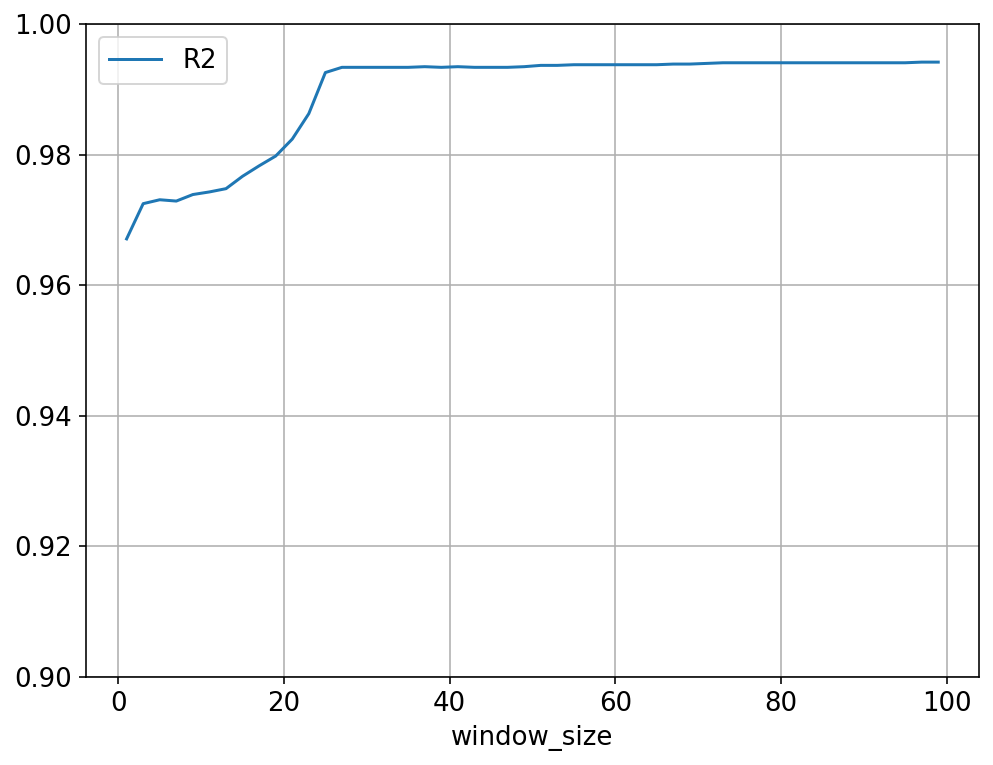

In [76]:
df_result = pd.DataFrame(result, columns=['window_size','R2'])
df_result.set_index('window_size', drop=True).plot(ylim=[0.9,1])
plt.grid(axis = 'both')

In [77]:
df_result['window_size'][df_result["R2"].idxmax()], df_result["R2"].max()

(97, 0.9942)

## LightGBM

In [78]:
result = []
model = lgbm_r
for window_size in range(1,100,2):
    df = df_power.copy()
    cols = {'load': window_size}
    future = [1]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+1'])]
    y = df_sh['load+1'].values
    score = model_run(model, X, y, shuffle=False)
    result.append((window_size, score))

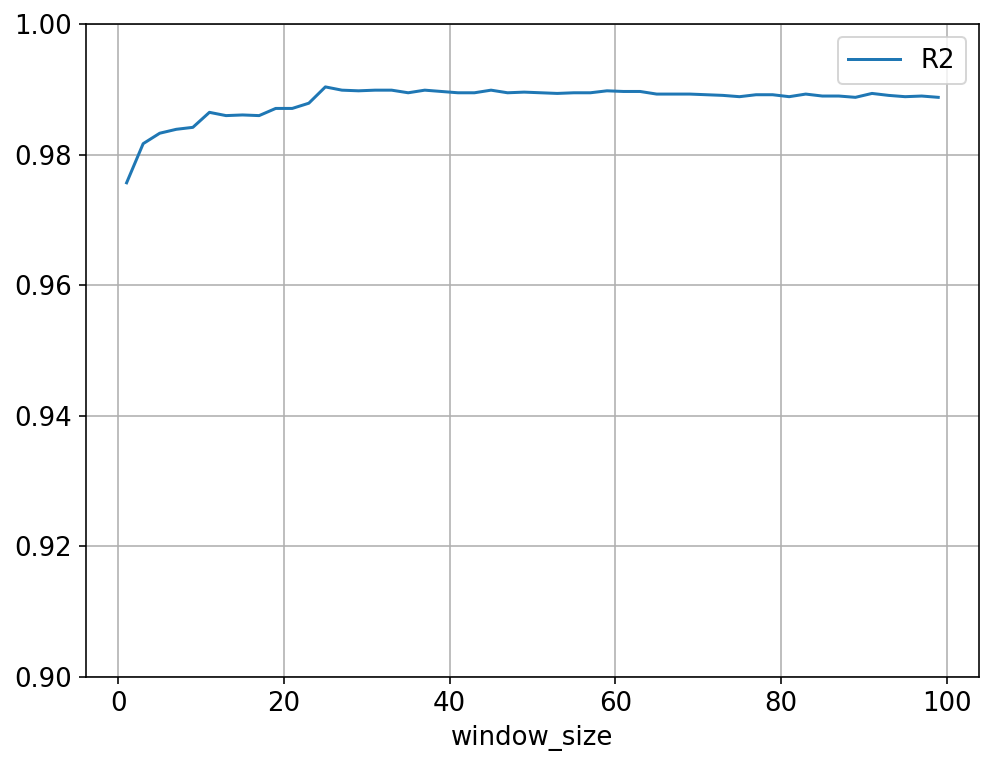

In [80]:
df_result = pd.DataFrame(result, columns=['window_size','R2'])
df_result.set_index('window_size', drop=True).plot(ylim=[0.9,1])
plt.grid(axis = 'both')

In [81]:
df_result['window_size'][df_result["R2"].idxmax()], df_result["R2"].max()

(25, 0.9904)

## 먼 미래 예측
- 윈도우 크기는 25로 고정
- 미래 24시간 후까지 예측하는 성능을 비교

In [103]:
model = lr
window_size = 25
result = []
for step in range(1,25):
    df = df_power.copy()
    cols = {'load': window_size}
    future = [step]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+'+str(step)])]
    y = df_sh['load+'+str(step)].values
    score = model_run(model, X, y, shuffle=False)
    result.append((step, score))

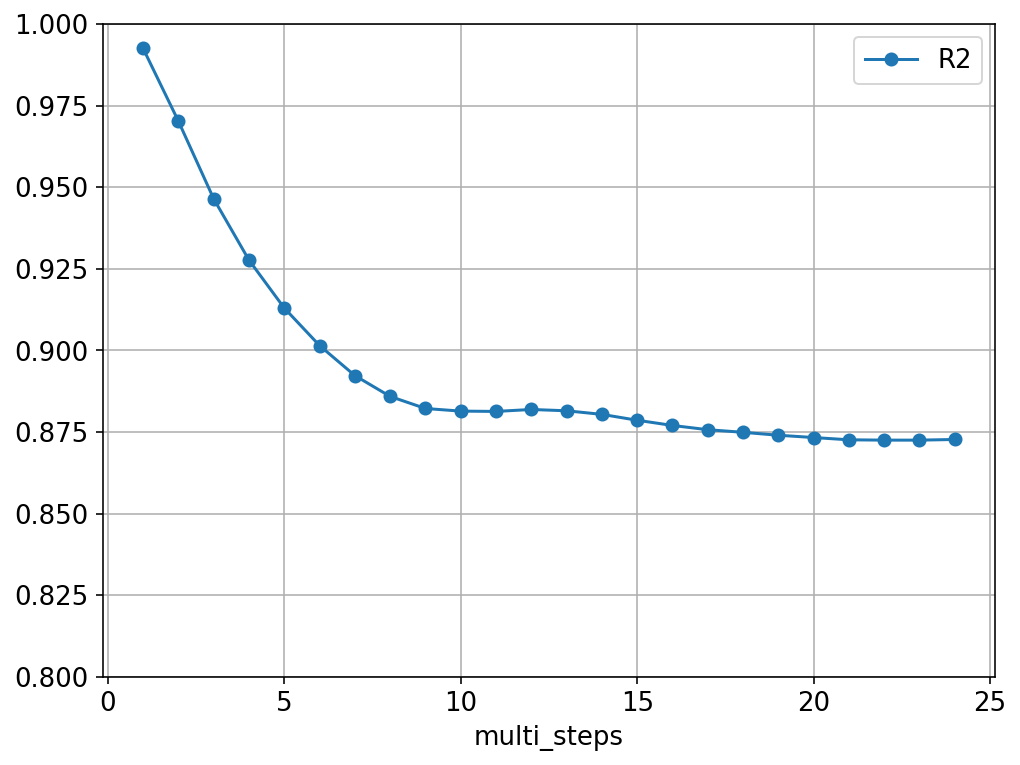

In [104]:
df_result = pd.DataFrame(result, columns=['multi_steps','R2'])
df_result.set_index('multi_steps', drop=True).plot(marker='o', ylim=[0.8,1])
plt.grid(axis = 'both')

In [105]:
model = lgbm_r
window_size = 25
result = []
for step in range(1,25):
    df = df_power.copy()
    cols = {'load': window_size}
    future = [step]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+'+str(step)])]
    y = df_sh['load+'+str(step)].values
    score = model_run(model, X, y, shuffle=False)
    result.append((step, score))

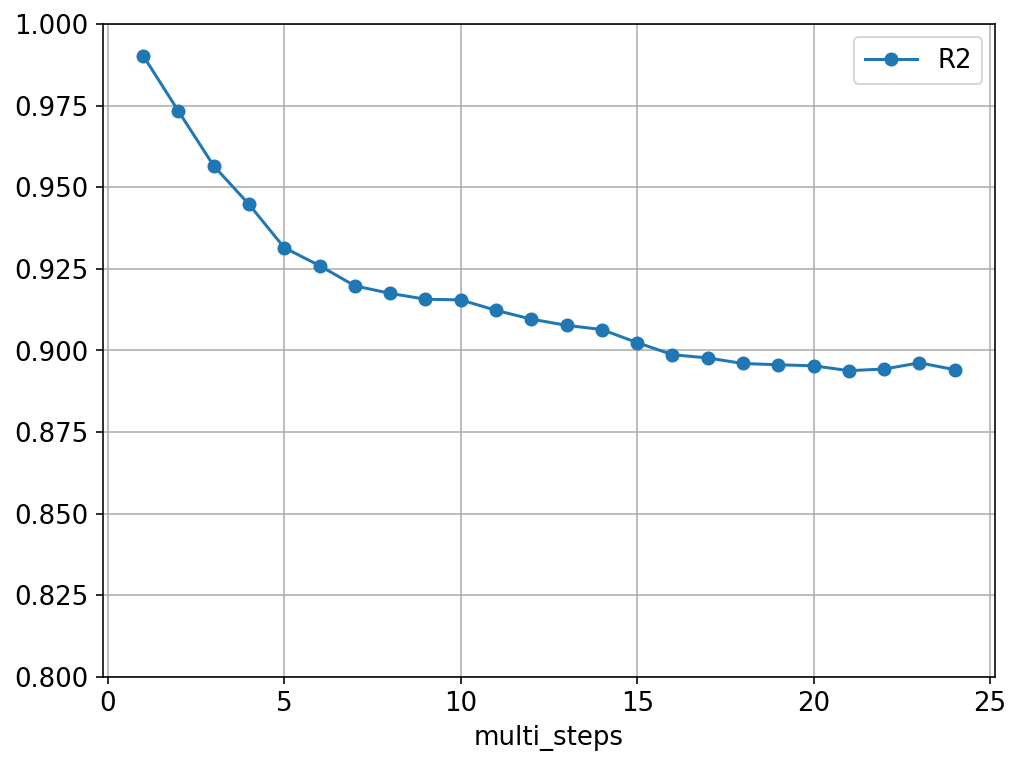

In [106]:
df_result = pd.DataFrame(result, columns=['multi_steps','R2'])
df_result.set_index('multi_steps', drop=True).plot(marker='o', ylim=[0.8,1])
plt.grid(axis = 'both')

# 시간 단위가 아니라 날자 단위로 예측

- 하루 단위 데이터로 다운 샘플링 하는 방법
- 하루의 전력 사용량 합계를 사용하겠다

In [90]:
power[:3]

,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


In [91]:
df_down = power.resample('D').sum()
print(df_down.shape)
df_down[:3]

(1096, 2)


,load,temp
timestamp,,
2012-01-01,71562.0,906.333333
2012-01-02,76841.0,897.666667
2012-01-03,87887.0,418.333333


- 기온은 시간단위의 합이 아니라 하루 평균치를 사용하겠다.

In [92]:
df_down['temp'] = power.temp.resample('D').mean()
df_down[:5]

,load,temp
timestamp,,
2012-01-01,71562.0,37.763889
2012-01-02,76841.0,37.402778
2012-01-03,87887.0,17.430556
2012-01-04,92168.0,13.111111
2012-01-05,88096.0,24.875000


## 단변수 예측 (전력량만 사용하는 경우)

In [94]:
# 일단위 시계열 데이터
df = df_down.copy()
print(df.shape)
df[:3]

(1096, 2)


,load,temp
timestamp,,
2012-01-01,71562.0,37.763889
2012-01-02,76841.0,37.402778
2012-01-03,87887.0,17.430556


## 시계열 모델

In [181]:
model = lr
result = []
for window_size in range(1,100,2):
    df = df_down.copy()
    cols = {'load': window_size}
    future = [1]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+1'])]
    y = df_sh['load+1'].values
    score = model_run(model, X, y, shuffle=False)
    result.append((window_size, score))

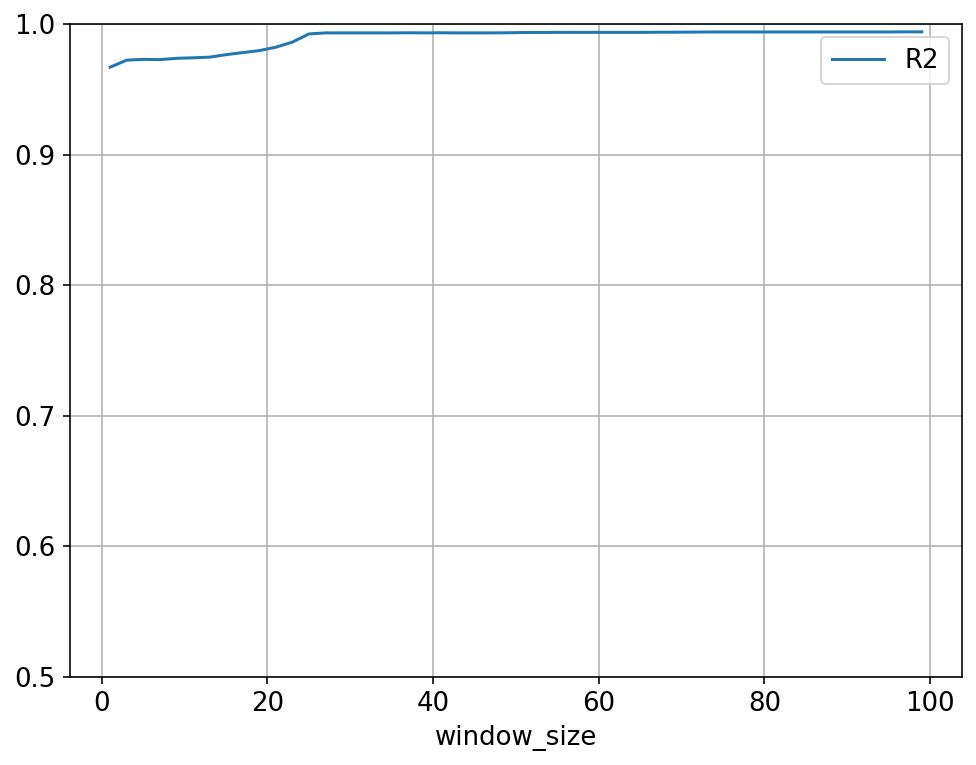

In [182]:
df_result = pd.DataFrame(result, columns=['window_size','R2'])
df_result.set_index('window_size', drop=True).plot(ylim=[0.5,1])
plt.grid(axis = 'both')

In [98]:
df_result['window_size'][df_result["R2"].idxmax()], df_result["R2"].max()

(57, 0.8107)

## LightGBM

In [99]:
result = []
model = lgbm_r
for window_size in range(1,100,2):
    df = df_down.copy()
    cols = {'load': window_size}
    future = [1]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+1'])]
    y = df_sh['load+1'].values
    score = model_run(model, X, y, shuffle=False)
    result.append((window_size, score))

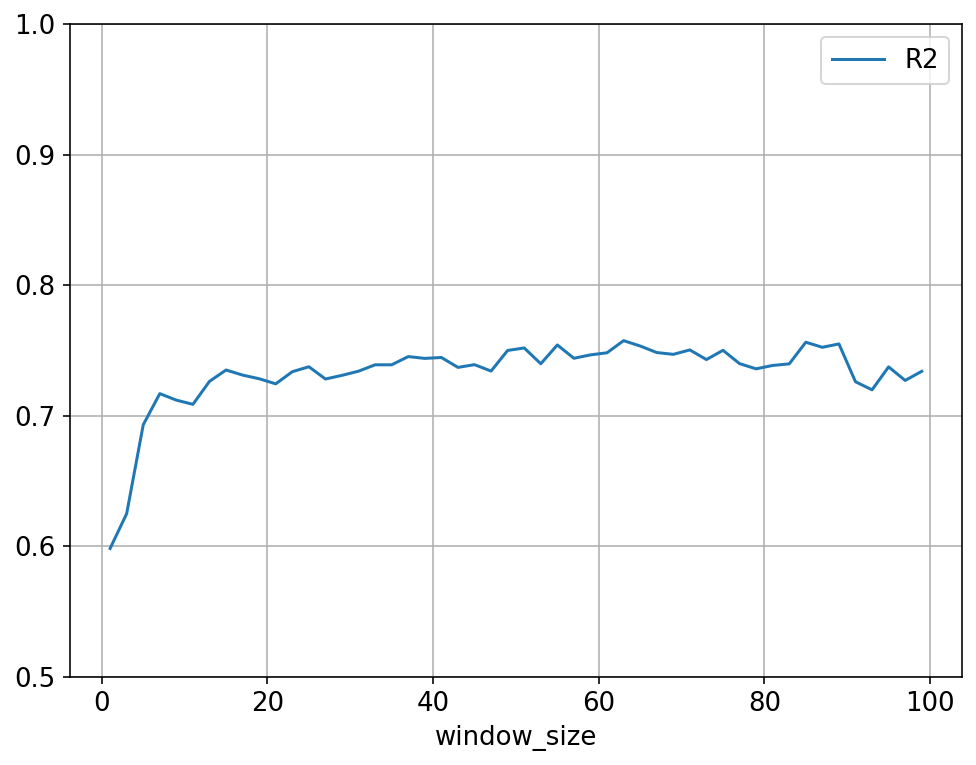

In [101]:
df_result = pd.DataFrame(result, columns=['window_size','R2'])
df_result.set_index('window_size', drop=True).plot(ylim=[0.5,1])
plt.grid(axis = 'both')

In [102]:
df_result['window_size'][df_result["R2"].idxmax()], df_result["R2"].max()

(63, 0.7575)

## 먼 미래 예측
- 윈도우 크기는 40으로 고정
- 미래 24시간 후까지 예측하는 성능을 비교

In [107]:
model = lr
window_size = 40
result = []
for step in range(1,25):
    df = df_down.copy()
    cols = {'load': window_size}
    future = [step]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+'+str(step)])]
    y = df_sh['load+'+str(step)].values
    score = model_run(model, X, y, shuffle=False)
    result.append((step, score))

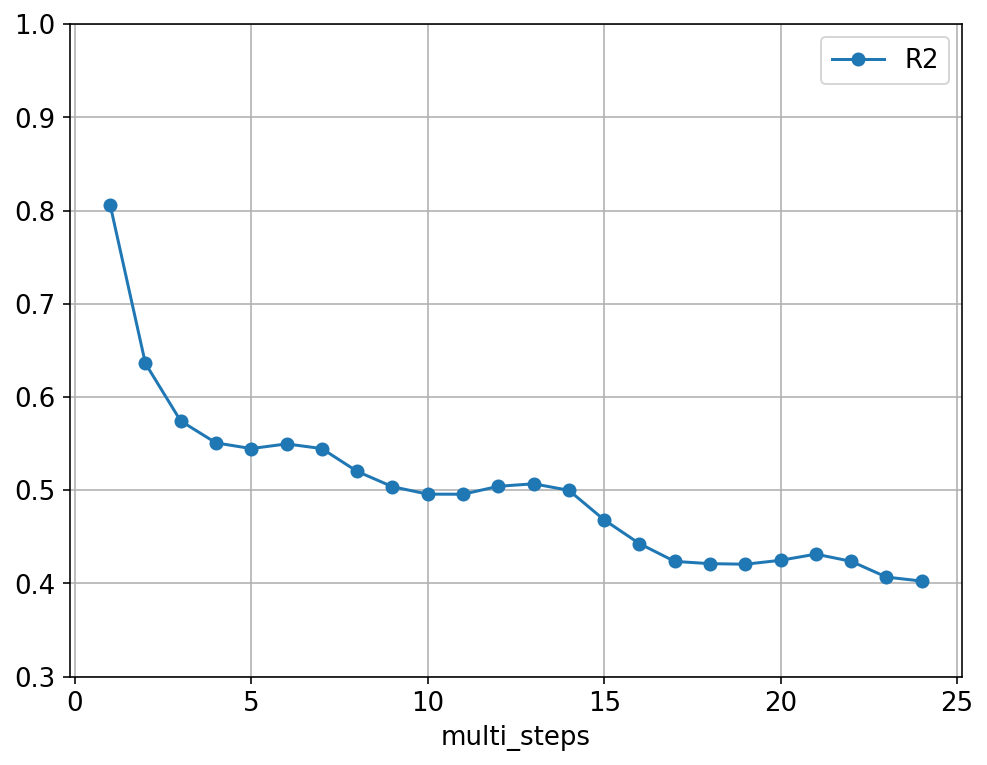

In [110]:
df_result = pd.DataFrame(result, columns=['multi_steps','R2'])
df_result.set_index('multi_steps', drop=True).plot(marker='o', ylim=[0.3,1])
plt.grid(axis = 'both')

In [111]:
model = lgbm_r
window_size = 40
result = []
for step in range(1,25):
    df = df_down.copy()
    cols = {'load': window_size}
    future = [step]
    df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['temp', 'load+'+str(step)])]
    y = df_sh['load+'+str(step)].values
    score = model_run(model, X, y, shuffle=False)
    result.append((step, score))

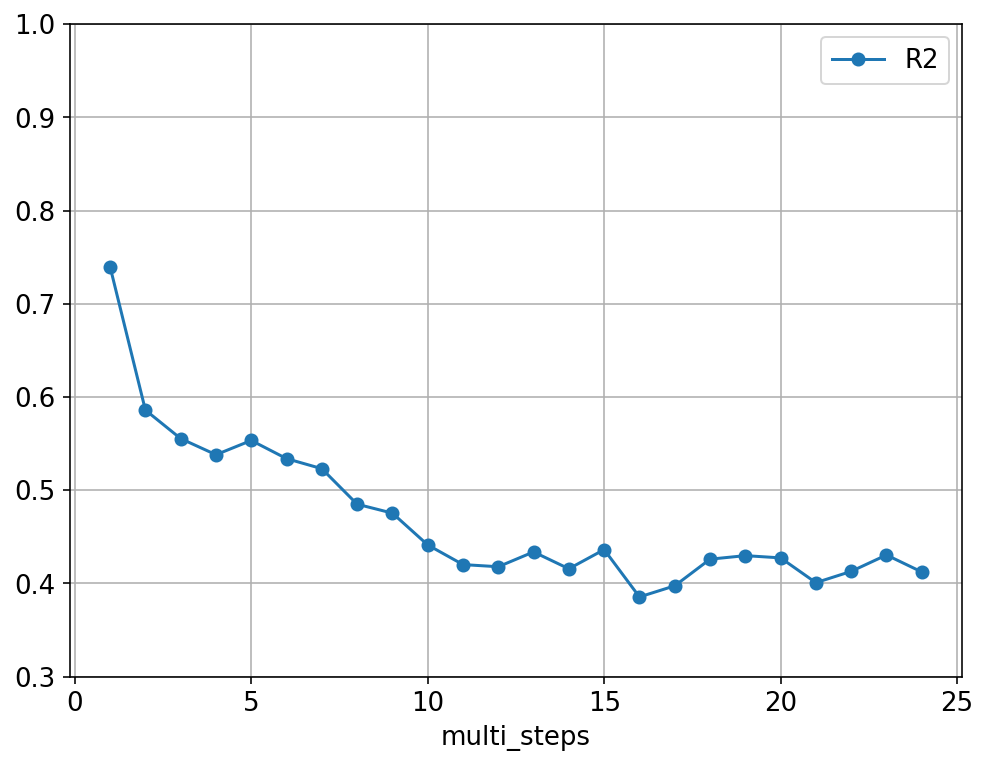

In [113]:
df_result = pd.DataFrame(result, columns=['multi_steps','R2'])
df_result.set_index('multi_steps', drop=True).plot(marker='o', ylim=[0.3,1])
plt.grid(axis = 'both')

# 다중변수 예측

- 자신의 과거 값과 다른 특성을 같이 사용하는 방법

## 다중 출력 예측

- 과거 15일치 전력사용량과 5일간의 날씨를 입력으로 사용하는 경우
- 미래 3일간 전력사용량을 예측

In [114]:
df_down[:5]

,load,temp
timestamp,,
2012-01-01,71562.0,37.763889
2012-01-02,76841.0,37.402778
2012-01-03,87887.0,17.430556
2012-01-04,92168.0,13.111111
2012-01-05,88096.0,24.875000


- 모든 특성을 사용하고 내일의 전력 사용량을 예측하는 경우

- 모델과 데이터를 주고 학습 수행후 성능을 평가하는 함수
- 디폴트로 shuffle=False 로 설정함 (시계열 데이터 이므로 과거 데이터로만 학습)

In [115]:
df = df_down.copy()

cols = {'load':40, 'temp':10}
future = list(range(1,8))
df_sh = get_table_multi_shifts(df, 'load', *future, **cols)
print(df_sh.shape)
df = df_sh.dropna()
print(df.shape)

(1096, 59)
(1049, 59)


In [116]:
df[:3].T


timestamp,2012-02-10,2012-02-11,2012-02-12
load,78609.000000,75922.000000,81470.000000
temp,32.222222,27.263889,12.708333
load-1,80213.000000,78609.000000,75922.000000
load-2,83039.000000,80213.000000,78609.000000
load-3,80065.000000,83039.000000,80213.000000
load-4,79866.000000,80065.000000,83039.000000
load-5,78345.000000,79866.000000,80065.000000
load-6,78043.000000,78345.000000,79866.000000
load-7,82814.000000,78043.000000,78345.000000
load-8,81645.000000,82814.000000,78043.000000


In [121]:
df.columns

Index(['load', 'temp', 'load-1', 'load-2', 'load-3', 'load-4', 'load-5',
       'load-6', 'load-7', 'load-8', 'load-9', 'load-10', 'load-11', 'load-12',
       'load-13', 'load-14', 'load-15', 'load-16', 'load-17', 'load-18',
       'load-19', 'load-20', 'load-21', 'load-22', 'load-23', 'load-24',
       'load-25', 'load-26', 'load-27', 'load-28', 'load-29', 'load-30',
       'load-31', 'load-32', 'load-33', 'load-34', 'load-35', 'load-36',
       'load-37', 'load-38', 'load-39', 'load-40', 'temp-1', 'temp-2',
       'temp-3', 'temp-4', 'temp-5', 'temp-6', 'temp-7', 'temp-8', 'temp-9',
       'temp-10', 'load+1', 'load+2', 'load+3', 'load+4', 'load+5', 'load+6',
       'load+7'],
      dtype='object')

In [118]:
targets = ['load+'+str(i) for i in range(1,8)]
print(targets)

['load+1', 'load+2', 'load+3', 'load+4', 'load+5', 'load+6', 'load+7']


In [122]:
features = df.columns.difference(targets)
features

Index(['load', 'load-1', 'load-10', 'load-11', 'load-12', 'load-13', 'load-14',
       'load-15', 'load-16', 'load-17', 'load-18', 'load-19', 'load-2',
       'load-20', 'load-21', 'load-22', 'load-23', 'load-24', 'load-25',
       'load-26', 'load-27', 'load-28', 'load-29', 'load-3', 'load-30',
       'load-31', 'load-32', 'load-33', 'load-34', 'load-35', 'load-36',
       'load-37', 'load-38', 'load-39', 'load-4', 'load-40', 'load-5',
       'load-6', 'load-7', 'load-8', 'load-9', 'temp', 'temp-1', 'temp-10',
       'temp-2', 'temp-3', 'temp-4', 'temp-5', 'temp-6', 'temp-7', 'temp-8',
       'temp-9'],
      dtype='object')

In [123]:
X = df[features]

timestamp,2012-02-10,2012-02-11,2012-02-12
load,78609.000000,75922.000000,81470.000000
load-1,80213.000000,78609.000000,75922.000000
load-10,84069.000000,81283.000000,81645.000000
load-11,83643.000000,84069.000000,81283.000000
load-12,75625.000000,83643.000000,84069.000000
load-13,74928.000000,75625.000000,83643.000000
load-14,81654.000000,74928.000000,75625.000000
load-15,81906.000000,81654.000000,74928.000000
load-16,81543.000000,81906.000000,81654.000000
load-17,79804.000000,81543.000000,81906.000000


### 선형, 랜덤포레스트, 부스팅 비교

In [126]:
result = []
for model in [lr, rfr, lgbm_r]:
    for i in range(1,8):
        y = df['load+'+str(i)]
        r2 = model_run(model, X, y, shuffle=False)
        result.append((model, i, r2))

NameError: name 'res' is not defined

In [169]:
df_r = pd.DataFrame(result, columns=['model','steps','r2'])
models = 7*['Linear']+7*['RandomForest']+7*['LGBM']
df_r['model'] = models
df_r[:10]

,model,steps,r2
0,Linear,1,0.8009
1,Linear,2,0.6278
2,Linear,3,0.5657
3,Linear,4,0.5438
4,Linear,5,0.5398
5,Linear,6,0.5485
6,Linear,7,0.5463
7,RandomForest,1,0.7439
8,RandomForest,2,0.5989
9,RandomForest,3,0.5491


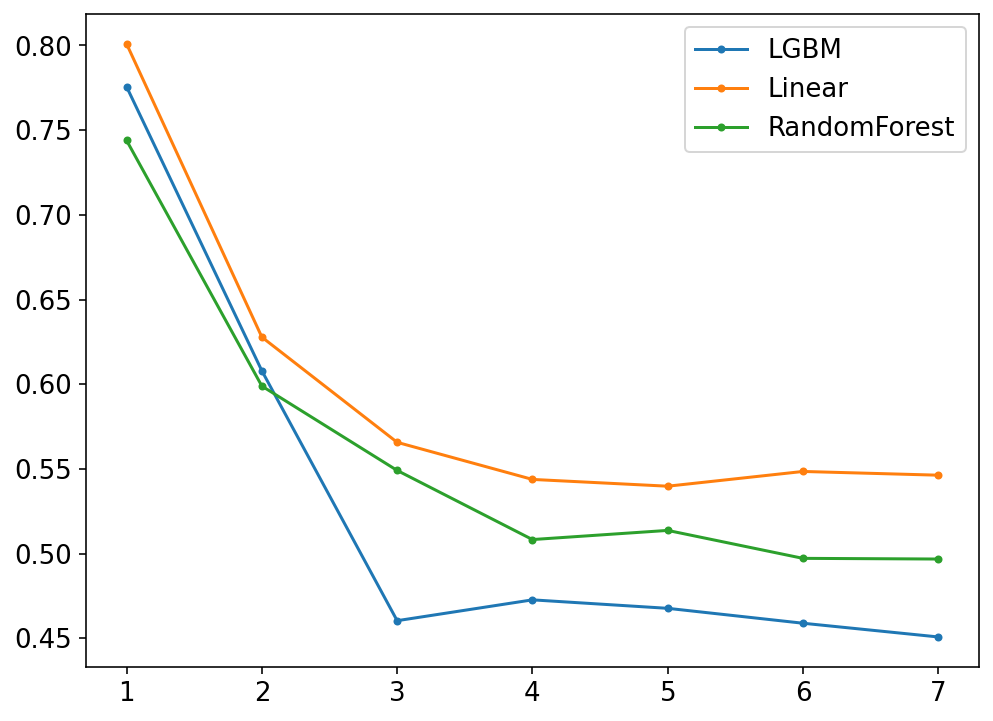

In [175]:
for model, group in df_r.groupby('model'):
    plt.plot(group['steps'], group['r2'], 
             marker='.', label=model)
plt.legend()

## 랜덤 포레스트 다중 예측
- 랜덤 포레스트는 한번에 여러개의 y 값을 예측하는 모델을 지원한다
- 아래는 y에 7개의 값을 한번에 예측하도록 했다

In [179]:
y = df[targets]
y[:3]

,load+1,load+2,load+3,load+4,load+5,load+6,load+7
timestamp,,,,,,,
2012-02-10,75922.0,81470.0,85615.0,81383.0,79858.0,78716.0,77652.0
2012-02-11,81470.0,85615.0,81383.0,79858.0,78716.0,77652.0,74391.0
2012-02-12,85615.0,81383.0,79858.0,78716.0,77652.0,74391.0,74512.0


In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        shuffle=False, random_state=9)
rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
r2_score(y_test, y_pred, multioutput='raw_values')

array([0.68934712, 0.53581278, 0.47985978, 0.46614133, 0.46649293,
       0.48749956, 0.4953188 ])

## 기타 특성 추가
- 이동평균, 이동분산, 최대-최소 차이, 평활화(ewma: Exponentially-weighted moving average) 등 특성을 추가할 수 있다

In [58]:
# 과거 5일간의 평균치를 컬럼에 추가
X2= X.copy()
X2["5-mean"] = X2.load.rolling(5,min_periods=1).mean()
X2[:5]

,load,load-1,load-2,load-3,load-4,load-5,temp,temp-1,temp-2,temp-3,temp-4,temp-5,5-mean
timestamp,,,,,,,,,,,,,
2012-01-06,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,25.902778,24.875000,13.111111,17.430556,37.402778,37.763889,85591.000000
2012-01-07,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,31.652778,25.902778,24.875000,13.111111,17.430556,37.402778,81230.000000
2012-01-08,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,30.000000,31.652778,25.902778,24.875000,13.111111,17.430556,80075.666667
2012-01-09,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,25.277778,30.000000,31.652778,25.902778,24.875000,13.111111,81511.250000
2012-01-10,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,33.013889,25.277778,30.000000,31.652778,25.902778,24.875000,82240.600000


- 다양한 특성 추가 예시
- ema에 지수형 가중값을 구한다
- min_periods=1 의 의미는 필요한 갯수가 되지 않더라도, 한개라도 평균 등을 계산하라는 뜻임 (초기 값들을 버리지 않기 위함)

In [60]:
X2["20-mean"] = X2.load.rolling(20,min_periods=1).mean()
X2["10-std"] = X2.load.rolling(10, min_periods=1).std().fillna(0)
X2['5EWMA'] = X2.load.ewm(span=5).mean()
X2["5-max"] = X2.load.rolling(5, min_periods=1).max()
X2["5-min"] = X2.load.rolling(5, min_periods=1).min()
X2["5-peak-difference"] = X2.load.rolling(5, min_periods=1).max()-X2.load.rolling(5, min_periods=1).min()
X2[:3]

,load,load-1,load-2,load-3,load-4,load-5,temp,temp-1,temp-2,temp-3,temp-4,temp-5,5-mean,20-mean,10-std,5EWMA,5-max,5-min,5-peak-difference
timestamp,,,,,,,,,,,,,,,,,,,
2012-01-06,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,25.902778,24.875000,13.111111,17.430556,37.402778,37.763889,85591.000000,85591.000000,0.000000,85591.000000,85591.0,85591.0,0.0
2012-01-07,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,31.652778,25.902778,24.875000,13.111111,17.430556,37.402778,81230.000000,81230.000000,6167.385346,80357.800000,85591.0,76869.0,8722.0
2012-01-08,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,30.000000,31.652778,25.902778,24.875000,13.111111,17.430556,80075.666667,80075.666667,4797.476142,79130.578947,85591.0,76869.0,8722.0


In [61]:
# X2를 사용하는 경우의 성능 비교 (아래에서 X2를 사용함)
res = []
for model in [lin, rfr, lgbm_r]:
    for i in range(1,4):
        y = df['y+'+str(i)]
        r2 = model_run(model, X2, y, shuffle=False)
        res.append((model, i, r2))
res

[(LinearRegression(), 1, 0.7011),
 (LinearRegression(), 2, 0.5213),
 (LinearRegression(), 3, 0.4473),
 (RandomForestRegressor(), 1, 0.7262),
 (RandomForestRegressor(), 2, 0.528),
 (RandomForestRegressor(), 3, 0.4366),
 (LGBMRegressor(), 1, 0.703),
 (LGBMRegressor(), 2, 0.5223),
 (LGBMRegressor(), 3, 0.3844)]

# 정답

## (연습) 윈도우가 7일 경우의 split_seq()를 수행해보시오

In [177]:
sequence = [1,2,3,4,5,6,7,8,9,10,11,12,13]
split_seq(sequence, 5)

(array([[ 1,  2,  3,  4,  5],
        [ 2,  3,  4,  5,  6],
        [ 3,  4,  5,  6,  7],
        [ 4,  5,  6,  7,  8],
        [ 5,  6,  7,  8,  9],
        [ 6,  7,  8,  9, 10],
        [ 7,  8,  9, 10, 11],
        [ 8,  9, 10, 11, 12]]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13]))

## (연습) 선형 예측 모델에서 과거 5일 및 15일을 사용할 때 각각의 성능을 구하시오

In [183]:
x_train, y_train = split_seq(train_data, 5)
x_test, y_test = split_seq(test_data, 5)
lin.fit(x_train, y_train) 
lin.score(x_test, y_test)

0.9333219796700054

In [184]:
x_train, y_train = split_seq(train_data, 15)
x_test, y_test = split_seq(test_data, 15)
lin.fit(x_train, y_train) 
lin.score(x_test, y_test)

0.9362455889020727

## (연습) 선형 예측 모델에서 과거 몇 개를 예측에 사용하면 성능이 가장 좋은지 최적 값을 찾으시오

- 힌트 n_steps 값을 바꾸어 본다 (1 ~ 180 일)
- 가장 성능이 좋을 때의 회귀 성능을 확인하시오

In [185]:
N = 180
result = []

for n_steps in range(1,N+1): 
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    lin.fit(x_train, y_train) 
    result.append((n_steps, lin.score(x_test, y_test)))
                  
result[:10]

[(1, 0.9278711483333497),
 (2, 0.9284242771093589),
 (3, 0.9318384895047028),
 (4, 0.933021894827026),
 (5, 0.9333219796700054),
 (6, 0.9344556836268625),
 (7, 0.9349083866978511),
 (8, 0.935610096333157),
 (9, 0.9355260563224183),
 (10, 0.9359804760059094)]

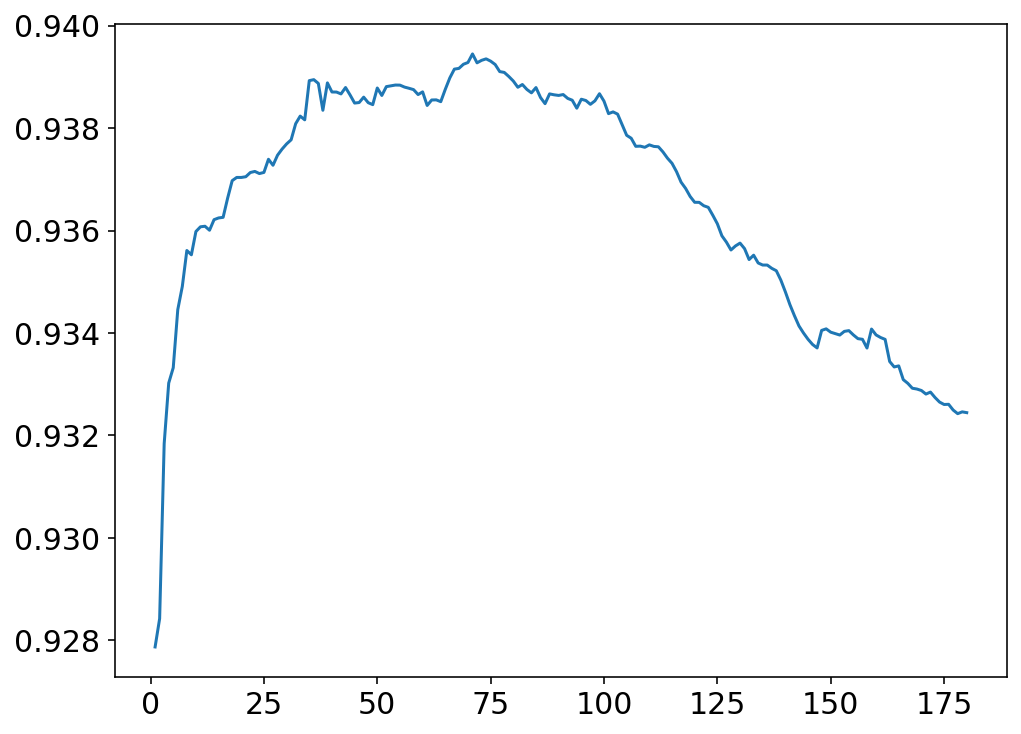

In [186]:
result = np.array(result)
plt.plot(result[:,0], result[:,1])

In [187]:
x_train, y_train = split_seq(train_data, 30)
x_test, y_test = split_seq(test_data, 30)
lin.fit(x_train, y_train) 
y_pred = lin.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  8.237
Mean Absolute Error:  1.481
Root Mean Squared Error:  1.912
R-Squared:  0.938


## (연습) 최적의 윈도우 값을 찾는 위의 예에서 결과를 리스트가 아니라 딕셔너리에 담아보시오

- 딕셔너리에 값을 담을 때는 key를 인자로 사용하고 값을 배정하면 된다
- 결과를 그래프로 그려보시오

In [196]:
# 리스트가 아니라 딕서너리에 결과를 담는 방법
result = {}
N = 20
for i in range(1,N+1): 
    n_steps=i
    x_test, y_test = split_seq(test_data, n_steps)
    y_pred = average_model(x_test)
    result[i]= r2_score(y_test, y_pred).round(4)

In [197]:
result

{1: 0.9266,
 2: 0.9166,
 3: 0.9113,
 4: 0.9074,
 5: 0.9037,
 6: 0.901,
 7: 0.8991,
 8: 0.8982,
 9: 0.8971,
 10: 0.896,
 11: 0.8948,
 12: 0.8932,
 13: 0.8913,
 14: 0.8897,
 15: 0.888,
 16: 0.8861,
 17: 0.8841,
 18: 0.8812,
 19: 0.8778,
 20: 0.8741}

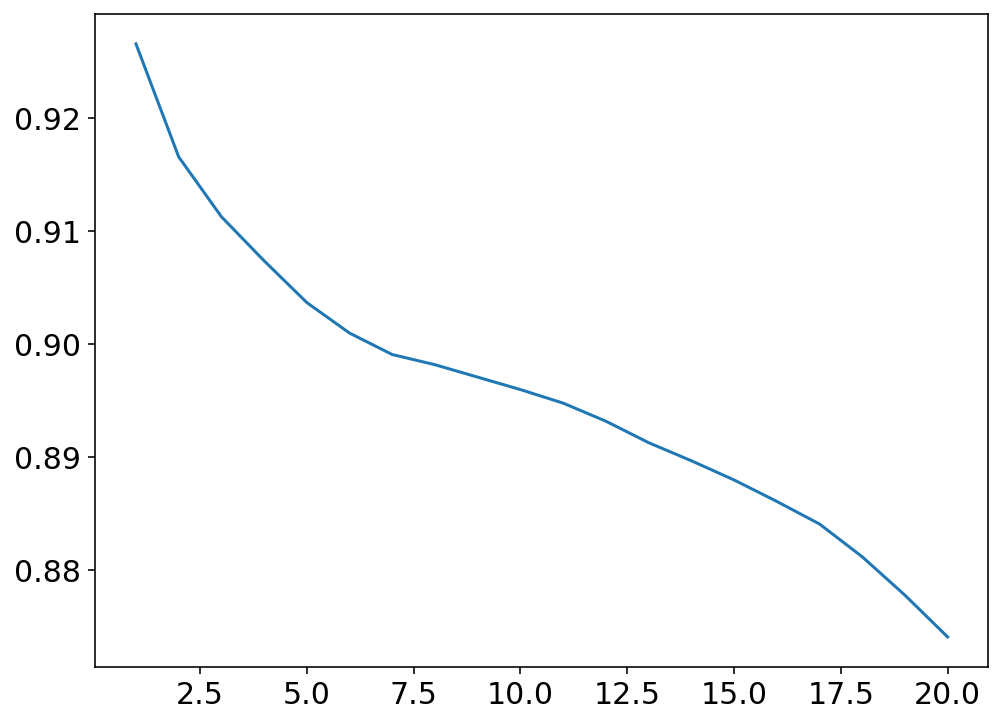

In [198]:
plt.plot(result.keys(),result.values())

In [199]:
# 최대값을 들어있는 항목의 키 찾기
# 최소값 찾는 함수는 min()
max(result, key=result.get)

1

## (연습) LightGBM 모델을 사용하고 윈도우 크기를 바꾸어 성능을 비교하시오

- lightgbm을 먼저 설치해야 한다 (!pip install lightgbm)
- 모델로 LGBMRegressor()를 사용한다

max R2:  0.735


Text(0.5, 1.0, 'R2 vs window size(LightGBM)')

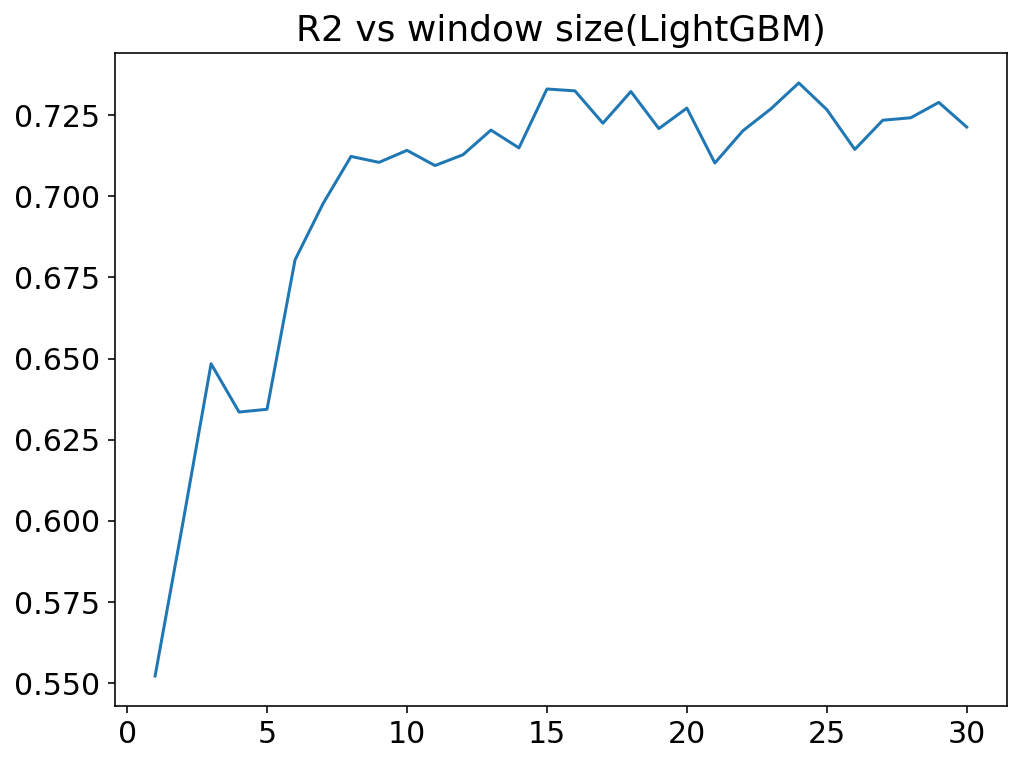

In [209]:
lgbm_r = LGBMRegressor()
N = 30
result = []

for n_steps in range(1,N+1): 
    r2 = split_seq_fit(lgbm_r, train_data, test_data, n_steps)
    result.append((n_steps, r2))
                  
result = np.array(result)
print("max R2: ", result[:,1].max().round(3))

plt.plot(result[:,0], result[:,1])
plt.title("R2 vs window size(LightGBM)")